# VISUAL PIPELINE

In [1]:
import numpy as np
from scipy.stats import pearsonr
import sys
from PyQt5 import QtWidgets
import os
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import pickle
import glob
import datetime

from Running_computation import compute_speed
from Ca_imaging import CaImagingDataManager
from face_camera import FaceCamDataManager
from visual_stim import VisualStim
import General_functions
from visualization_GUI import MainWindow
import Photodiode
from inputUI import InputWindow
import red_cell_function
import utils.file as file
from trial import Trial
import behavioral_states

## Constants

In [2]:
COMPILE = False

## Parameters

In [3]:
# paths
base_path = "C:/Users/mai-an.nguyen/Documents/16-00-59"
red_image_path = 'C:/Users/mai-an.nguyen/Documents/16-00-59/SingleImage-red/red.tif'
compile_dir = ''

# analysis settings
neuropil_impact_factor = 0.7
F0_method = 'sliding' #sliding or hamming
neuron_type = 'Other' #PYR or Other
starting_delay_2p = 0.100
num_samples = 1000

speed_threshold = 0.5
facemotion_threshold = 2
pupil_threshold = 2

min_run_window = 3.5
min_as_window = 2.5
min_rest_window = 1.5

speed_filter_kernel = 10
motion_filter_kernel = 10
pupil_filter_kernel = 10
dFoF_filter_kernel = 10

## Load Data

In [4]:
# Get metadata
unique_id, global_protocol, experimenter, subject_id = file.get_metadata(base_path)
subject_id_anibio = file.get_mouse_id(base_path, subject_id)

No excel file for mouse metadata found : C:/Users/mai-an.nguyen/Documents/16-00-59\demo-Mouse.xlsx


In [5]:
# Load Ca-Imaging data
ca_img_dm = CaImagingDataManager(base_path, neuropil_impact_factor, F0_method, neuron_type, starting_delay_2p)
ca_img_dm.save_mean_image(base_path)
detected_roi = ca_img_dm._list_ROIs_idx
print('Original number of neurons :', len(detected_roi))

Mean_image_grayscale.png already exist.
Original number of neurons : 35


In [6]:
# Load Camera data
timestamp_start = Photodiode.get_timestamp_start(base_path)
face_cam_dm = FaceCamDataManager(base_path, timestamp_start)

C:/Users/mai-an.nguyen/Documents/16-00-59\FaceIt\FaceIt.npz doesn't exist.


In [7]:
# Compute speed
speed, speed_time_stamps = compute_speed(base_path)

In [8]:
# Resample facemotion, pupil and speed traces
if not face_cam_dm.no_face_data :
    last_F_index = np.argmin(np.abs(ca_img_dm.time_stamps - face_cam_dm.time_stamps[-1]))
    ca_img_dm.cut_frames(last_index=last_F_index) #update metrics with new frames length
new_time_stamps = ca_img_dm.time_stamps
total_duration = ca_img_dm.time_stamps[-1] - ca_img_dm.time_stamps[0]
print(f"Total duration of the recording: {total_duration} s")

#sub sampling and filtering speed
speed = General_functions.resample_signal(speed, 
                                          t_sample=speed_time_stamps, 
                                          new_freq=ca_img_dm.fs,
                                          interp_time=new_time_stamps,
                                          post_smoothing=2./50.)

if not face_cam_dm.no_face_data :
    pupil = General_functions.resample_signal(face_cam_dm.pupil, 
                                              t_sample=face_cam_dm.time_stamps, 
                                              new_freq=ca_img_dm.fs, 
                                              interp_time=new_time_stamps)
    facemotion = General_functions.resample_signal(face_cam_dm.facemotion, 
                                                   t_sample=face_cam_dm.time_stamps,
                                                   new_freq=ca_img_dm.fs, 
                                                   interp_time=new_time_stamps)

    # Normalize
    pupil = General_functions.scale_trace(pupil)
    facemotion = General_functions.scale_trace(facemotion)
else :
    facemotion, pupil = [np.nan] * len(new_time_stamps), [np.nan] * len(new_time_stamps)

Total duration of the recording: 2622.907376334 s


In [9]:
# Load Photodiode data
NIdaq, acq_freq = Photodiode.load_and_data_extraction(base_path)
Psignal_time, Psignal = General_functions.resample_signal(NIdaq['analog'][0],
                                                          original_freq=acq_freq,
                                                          new_freq=1000)

In [10]:
# Load Stimuli data
visual_stim = VisualStim(base_path)
protocol_df = visual_stim.protocol_df
print(protocol_df)

                        name  duration
id                                    
0                moving-dots       3.0
1                random-dots       3.0
2               static-patch       1.0
3               looming-stim       5.0
4   Natural-Images-4-repeats       2.0
5                 grey-20min    1200.0
6          drifting-gratings       3.0


## Create saving folder

In [ ]:
# Create saving folder
#save_dir, save_fig_dir, id_version = file.create_output_folder(base_path, unique_id)

id_version = '14'
save_dir = os.path.join(base_path, "_".join([unique_id, 'output', id_version]))
save_fig_dir = os.path.join(save_dir, "_".join([unique_id, 'figures']))


print(save_dir)
print(save_fig_dir)

C:/Users/mai-an.nguyen/Documents/16-00-59\2024_09_03_16-00-59_output_14
C:/Users/mai-an.nguyen/Documents/16-00-59\2024_09_03_16-00-59_output_14\2024_09_03_16-00-59_figures


## Calcium Imaging Pre-processing

In [12]:
# Detect ROIs with bad neuropils
ca_img_dm.detect_bad_neuropils()
kept2p_ROI = ca_img_dm._list_ROIs_idx
print('After removing bad neuropil neurons, nb of neurons :', len(kept2p_ROI))

After removing bad neuropil neurons, nb of neurons : 31


In [13]:
# Compute Fluorescence 
ca_img_dm.compute_F()
kept_ROI_alpha = ca_img_dm._list_ROIs_idx
print('Number of remaining neurons after alpha calculation :', len(kept_ROI_alpha))

Number of remaining neurons after alpha calculation : 31


In [14]:
# Calculation of F0
ca_img_dm.compute_F0(percentile=10, win=60)
kept_ROI_F0 = ca_img_dm._list_ROIs_idx
print('Number of remaining neurons after F0 calculation  :', len(kept_ROI_F0))

Number of remaining neurons after F0 calculation  : 30


In [15]:
# Calculation of dF over F0
ca_img_dm.compute_dFoF0()
computed_F_norm = ca_img_dm.normalize_time_series("dFoF0", lower=0, upper=5)

In [16]:
# Plot calcium imaging traces
ca_img_dm.plot('f0', sigma=0, mean=True, save_dir=save_fig_dir, legend=True)
ca_img_dm.plot('fluorescence', sigma=10, save_dir=save_fig_dir, legend=True)
ca_img_dm.plot('dFoF0', sigma=10, save_dir=save_fig_dir, legend=True)
ca_img_dm.plot_raster('fluorescence', sigma=10, save_dir=save_fig_dir)
ca_img_dm.plot_raster('dFoF0', sigma=10, save_dir=save_fig_dir)

## Correlation

In [17]:
speed_corr_list = [pearsonr(speed, ROI)[0] for ROI in ca_img_dm.dFoF0]
facemotion_corr_list = [pearsonr(facemotion, ROI)[0] for ROI in ca_img_dm.dFoF0]
pupil_corr_list = [pearsonr(pupil, ROI)[0] for ROI in ca_img_dm.dFoF0]

## Compute behavioral states

In [18]:
min_states_window = {'run' : round(min_run_window * ca_img_dm.fs), 
                     'AS' : round(min_as_window * ca_img_dm.fs), 
                     'rest' : round(min_rest_window * ca_img_dm.fs)}

if not face_cam_dm.no_face_data :
    # Facemotion threshold
    real_time_states_facemotion, states_window_facemotion =\
        behavioral_states.split_stages(speed, facemotion, speed_threshold, facemotion_threshold, 
                                       ca_img_dm.time_stamps, min_states_window, ca_img_dm.fs, 
                                       'facemotion', speed_filter_kernel, motion_filter_kernel)

    behavioral_states.stage_plot(speed, facemotion, pupil, ca_img_dm.dFoF0, 
                                 ca_img_dm.time_stamps, real_time_states_facemotion, states_window_facemotion, 
                                 save_fig_dir, speed_threshold, facemotion_threshold,'facemotion', 
                                 speed_filter_kernel, motion_filter_kernel, pupil_filter_kernel, dFoF_filter_kernel,
                                 svg=False)

    run_ratio_facemotion, as_ratio_facemotion, rest_ratio_facemotion =\
        behavioral_states.time_pie(real_time_states_facemotion, total_duration, 
                                   save_fig_dir,figname="states_duration_pie_facemotion")

    # Pupil threshold
    real_time_states_pupil, states_window_pupil =\
        behavioral_states.split_stages(speed, pupil, speed_threshold, pupil_threshold, 
                                       ca_img_dm.time_stamps, min_states_window, ca_img_dm.fs, 
                                       'pupil', speed_filter_kernel, pupil_filter_kernel)

    behavioral_states.stage_plot(speed, facemotion, pupil, ca_img_dm.dFoF0, 
                                 ca_img_dm.time_stamps, real_time_states_pupil, states_window_pupil, 
                                 save_fig_dir, speed_threshold, pupil_threshold, 'pupil', 
                                 speed_filter_kernel, motion_filter_kernel,  pupil_filter_kernel, dFoF_filter_kernel, 
                                 svg=False)

    run_ratio_pupil, as_ratio_pupil, rest_ratio_pupil =\
        behavioral_states.time_pie(real_time_states_pupil, total_duration, 
                                   save_fig_dir, figname="states_duration_pie_pupil")
else :
    real_time_states, states_window =\
        behavioral_states.split_stages_locomotion(speed, speed_threshold, 
                                                  ca_img_dm.time_stamps, min_states_window, ca_img_dm.fs, speed_filter_kernel)

    behavioral_states.stage_plot_locomotion(speed, ca_img_dm.dFoF0, 
                                            ca_img_dm.time_stamps, real_time_states, states_window, 
                                            save_fig_dir, speed_threshold, speed_filter_kernel, 
                                            dFoF_filter_kernel,
                                            svg=False)

    run_ratio, rest_ratio =\
        behavioral_states.time_pie_locomotion(real_time_states, total_duration, 
                                   save_fig_dir,figname="states_duration_pie")

## Align times series

In [19]:
# Set real stimuli onset with photodiode
visual_stim.realign_from_photodiode(Psignal_time, Psignal)
Psignal = General_functions.scale_trace(Psignal)

In [20]:
# Stimuli start times and durations with calcium imaging data as a the basis
stim_time_end = list(visual_stim.real_time_onset + visual_stim.duration)
stim_time_period = [visual_stim.real_time_onset, stim_time_end]

F_Time_start_realigned, F_stim_init_indexes  = Photodiode.Find_F_stim_index(visual_stim.real_time_onset, ca_img_dm.time_stamps)

## Trial-averaging

In [21]:
# Method : 5 z-score auc
trials = Trial(ca_img_dm, visual_stim, F_stim_init_indexes, attr='dFoF0', dt_pre_stim=1, dt_post_stim=0.5)
trial_zscores, pre_trial_zscores, post_trial_zscores = trials.compute_trial_zscores('dFoF0')

if not face_cam_dm.no_face_data :
    real_time_states_sorted = behavioral_states.sort_dict_el(real_time_states_pupil)
else :
    real_time_states_sorted = behavioral_states.sort_dict_el(real_time_states)

for i in range(len(protocol_df)):    
    if visual_stim.stim_cat[i] :
        trials.trial_average_rasterplot(i, save_fig_dir) #plot trial-average raster
        trials.trial_rasterplot(trial_zscores, pre_trial_zscores, post_trial_zscores, i, 'dFoF0', savepath=save_fig_dir) #plot trials raster
        #trials.trial_rasterplot(trials.trial_zscores, trials.pre_trial_zscores, i, trials.post_trial_zscores, trials.ca_attr, savepath=save_fig_dir)
        trials.plot_stim_occurence(i, trial_zscores, pre_trial_zscores, real_time_states_sorted, F_Time_start_realigned,
                               save_dir, file_prefix="_".join([unique_id, id_version]))
        for k in range(len(ca_img_dm._list_ROIs_idx)):
            trials.plot_stim_response(i, k, save_dir, file_prefix="_".join([unique_id, id_version]))

filename = "_".join([unique_id, id_version, 'protocol_validity_2'])
trials.save_protocol_validity(save_dir, filename)

In [22]:
# Method : Bootstrapping
protocol_validity = []
for protocol in range(len(protocol_df)):
    chosen_protocol = protocol_df.index[protocol]
    protocol_duration = protocol_df['duration'][protocol]
    protocol_name = protocol_df['name'][protocol]
    protocol_validity_i = Photodiode.average_image(ca_img_dm.dFoF0, visual_stim.order, chosen_protocol,protocol_duration, protocol_name, F_stim_init_indexes, ca_img_dm.fs, num_samples, save_dir, file_prefix="_".join([unique_id, id_version]))
    protocol_validity.append(protocol_validity_i)

filename_protocol = "_".join([unique_id, id_version, 'protocol_validity']) + ".npz"
np.savez(os.path.join(save_dir, filename_protocol), **{key: value for d in protocol_validity for key, value in d.items()})
print(protocol_validity)

moving-dots 0 3.0
random-dots 1 3.0
static-patch 2 1.0
looming-stim 3 5.0
Natural-Images-4-repeats 4 2.0
grey-20min 5 1200.0
drifting-gratings 6 3.0
[{'moving-dots': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'random-dots': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'static-patch': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])}, {'looming-stim': array([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.])}, {'Natural-Images-4-repeats': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'grey-20min': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

## Spontaneous behavior

Spontaneous activity time 0: from 328.06002912 s to 1528.0039471399998 s


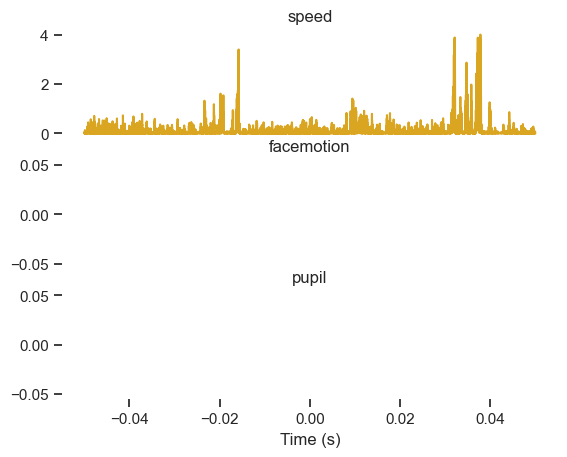

In [23]:
spont_speed_corr_list = []
spont_facemotion_corr_list = []
spont_pupil_corr_list = []
spont_stimuli_name = []
spont_stimuli_id = []
analyze_pupil = []
for stimuli_name in visual_stim.protocol_names :
    if 'grey' in stimuli_name :
        if stimuli_name not in spont_stimuli_name :
            spont_stimuli_name.append(stimuli_name)
            analyze_pupil.append(1)
    elif 'black' in stimuli_name :
        if stimuli_name not in spont_stimuli_name :
            spont_stimuli_name.append(stimuli_name)
            analyze_pupil.append(0)

if len(spont_stimuli_name) > 0 :
    for el in spont_stimuli_name :
        id_spont = protocol_df[protocol_df['name'] == el].index[0]
        spont_stimuli_id.append(id_spont)

    idx_lim_protocol, spont_stimuli_id_order, F_spontaneous = visual_stim.get_protocol_onset_index(spont_stimuli_id, F_stim_init_indexes, ca_img_dm.fs, tseries=ca_img_dm.dFoF0)

    analyze_pupil_order = dict(zip(spont_stimuli_id, analyze_pupil))

    for i, id  in zip(range(len(spont_stimuli_id_order)), spont_stimuli_id_order):
        [start_spont_index, end_spont_index] = idx_lim_protocol[i]

        # Correlation with dFoF0
        speed_spont = speed[start_spont_index:end_spont_index]
        speed_corr = [pearsonr(speed_spont, ROI)[0] for ROI in F_spontaneous[i]]
        speed_corr = [float(value) for value in speed_corr]
        spont_speed_corr_list.append(speed_corr)

        facemotion_spont = facemotion[start_spont_index:end_spont_index]
        facemotion_corr = [pearsonr(facemotion_spont, ROI)[0] for ROI in F_spontaneous[i]]
        facemotion_corr = [float(value) for value in facemotion_corr]
        spont_facemotion_corr_list.append(facemotion_corr)

        pupil_spont = pupil[start_spont_index:end_spont_index]
        if analyze_pupil_order[id] :
            pupil_corr = [pearsonr(pupil_spont, ROI)[0] for ROI in F_spontaneous[i]]
            pupil_corr = [float(value) for value in pupil_corr]
            spont_pupil_corr_list.append(pupil_corr)

        time_stamps_spont = new_time_stamps[start_spont_index:end_spont_index]
        print(f"Spontaneous activity time {i}: from {time_stamps_spont[0]} s to {time_stamps_spont[-1]} s")

        ax1 = plt.subplot(311)
        ax1.plot(time_stamps_spont, speed_spont, color='goldenrod')
        ax1.set_title('speed')
        ax1.set_xticks([])
        ax2 = plt.subplot(312)
        ax2.plot(time_stamps_spont, facemotion_spont, color='gray')
        ax2.set_title('facemotion')
        ax2.set_xticks([])
        ax3 = plt.subplot(313)
        ax3.plot(time_stamps_spont, pupil_spont, color='black')
        ax3.set_title('pupil')
        ax3.set_xlabel('Time (s)')
        plt.show()

    mean_speed_corr = np.mean(spont_speed_corr_list, axis=0)
    mean_facemotion_corr = np.mean(spont_facemotion_corr_list, axis=0)
    if len(spont_pupil_corr_list) > 0 :
        mean_pupil_corr = np.mean(spont_pupil_corr_list, axis=0)
    else :
        nb_rois = len(ca_img_dm.dFoF0)
        mean_pupil_corr = list(np.zeros(nb_rois))
else : 
    nb_rois = len(ca_img_dm.dFoF0)
    mean_speed_corr, mean_facemotion_corr, mean_pupil_corr = np.mean(speed_corr_list), np.mean(facemotion_corr_list), np.mean(pupil_corr_list)

## Set variables for saving and GUI

In [24]:
# for saving file
photodiode = (Psignal_time, Psignal)
pupilAndTimeSt  = (new_time_stamps, pupil)
fmotionAndTimeSt  = (new_time_stamps, facemotion)
speedAndTimeSt = (new_time_stamps, speed)
background_image_path = os.path.join(base_path, "Mean_image_grayscale.png")
filename_protocol = "_".join([unique_id, id_version, 'protocol_validity']) + ".npz"
protocol_validity_npz = np.load(os.path.join(save_dir, filename_protocol))

## Save ouptut files

### HDF5 file

In [25]:
filename = "_".join([unique_id, id_version, 'postprocessing']) + ".h5"
H5_dir = os.path.join(save_dir, filename)
hf = h5py.File(H5_dir, 'w')
behavioral_group = hf.create_group('Behavioral')
correlation = behavioral_group.create_group("Correlation")
spont_correlation = behavioral_group.create_group("Spont_correlation")
caImg_group = hf.create_group('Ca_imaging')
caImg_full_trace = caImg_group.create_group('full_trace')
stimuli_group = hf.create_group("Stimuli")
rois_group = hf.create_group("ROIs")
states_group = hf.create_group("Arousal states")
if not face_cam_dm.no_face_data :
    states_with_pupil = states_group.create_group("Arousal states pupil")
    frame_bounds_pupil = states_with_pupil.create_group("Frame bounds")
    time_bounds_pupil = states_with_pupil.create_group("Time bounds")
    states_with_facemotion = states_group.create_group("Arousal states facemotion")
    frame_bounds_facemotion = states_with_facemotion.create_group("Frame bounds")
    time_bounds_facemotion = states_with_facemotion.create_group("Time bounds")
else :
    frame_bounds = states_group.create_group("Frame bounds")
    time_bounds = states_group.create_group("Time bounds")

file.create_H5_dataset(behavioral_group, [speedAndTimeSt, facemotion, pupil, photodiode], ['Speed', 'FaceMotion', 'Pupil', 'Photodiode'])
file.create_H5_dataset(correlation, [speed_corr_list, facemotion_corr_list, pupil_corr_list], ['speed_corr', 'facemotion_corr', 'pupil_corr'])
if len(spont_stimuli_name) > 0 :
    file.create_H5_dataset(spont_correlation, [spont_speed_corr_list, spont_facemotion_corr_list, spont_pupil_corr_list], ['speed_corr', 'facemotion_corr', 'pupil_corr'])
caImg_group.create_dataset('Time', data=ca_img_dm.time_stamps)
file.create_H5_dataset(caImg_full_trace, [ca_img_dm.raw_F, ca_img_dm.raw_Fneu, ca_img_dm.fluorescence, ca_img_dm.f0, ca_img_dm.dFoF0], 
                                    ['raw_F', 'raw_Fneu', 'F', 'F0', 'dFoF0'])
file.create_H5_dataset(stimuli_group, [visual_stim.real_time_onset, F_Time_start_realigned, F_stim_init_indexes], 
                                    ['time_onset', 'time_onset_caimg_timescale', 'idx_onset_caimg_timescale'])
file.create_H5_dataset(rois_group, [detected_roi, kept2p_ROI, kept_ROI_alpha, kept_ROI_F0], 
                                    ['0_original', '1_neuropil', '2_alpha', '3_F0'])
if not face_cam_dm.no_face_data :
    file.create_H5_dataset(frame_bounds_pupil, [states_window_pupil['run'], states_window_pupil['AS'], states_window_pupil['rest']], ['Run', 'AS', 'Rest'])
    file.create_H5_dataset(time_bounds_pupil, [real_time_states_pupil['run'], real_time_states_pupil['AS'], real_time_states_pupil['rest']], ['Run', 'AS', 'Rest'])
    file.create_H5_dataset(frame_bounds_facemotion, [states_window_facemotion['run'], states_window_facemotion['AS'], states_window_facemotion['rest']], ['Run', 'AS', 'Rest'])
    file.create_H5_dataset(time_bounds_facemotion, [real_time_states_facemotion['run'], real_time_states_facemotion['AS'], real_time_states_facemotion['rest']], ['Run', 'AS', 'Rest'])
else :
    file.create_H5_dataset(frame_bounds, [states_window['run'], states_window['rest']], ['Run', 'Rest'])
    file.create_H5_dataset(time_bounds, [real_time_states['run'], real_time_states['rest']], ['Run', 'Rest'])

hf.close()

### Calcium imaging stat.npy file

In [26]:
filename = "_".join([unique_id, id_version, 'stat.npy'])
np.save(os.path.join(save_dir, filename), ca_img_dm.stat, allow_pickle=True)

### Compilation excel sheet

In [27]:
if COMPILE :
    data_df = pd.DataFrame({
                "Session_id": unique_id, "Protocol": global_protocol, "Experimenter": experimenter, "Mouse_id": subject_id_anibio,
                'Mean_speed' : np.nanmean(speed), 'Std_speed' : np.nanstd(speed),
                'Mean_fmotion' : np.nanmean(facemotion), 'Std_fmotion' : np.nanstd(facemotion),
                'Mean_pupil' : np.nanmean(pupil), 'Std_pupil' : np.nanstd(pupil),
                'Spontaneous' : True if len(spont_stimuli_name) > 0 else False,
                'Mean_speed_corr' : np.nanmean(mean_speed_corr), 'Mean_fmotion_corr' : np.nanmean(mean_facemotion_corr), 'Mean_pupil_corr' : np.nanmean(mean_pupil_corr), 
                'Mean_dFoF0' : np.nanmean(ca_img_dm.dFoF0), 
                'Run % (pupil)' : run_ratio_pupil, 'AS % (pupil)' : as_ratio_pupil, 'Rest % (pupil)' : rest_ratio_pupil,
                'Run % (motion)' : run_ratio_facemotion, 'AS % (motion)' : as_ratio_facemotion, 'Rest % (motion)' : rest_ratio_facemotion,
                }, index=[0]).set_index("Session_id")
    file.compile_xlsx_file(data_df, compile_dir)

### Analysis settings

In [28]:
settings = {"Date" : datetime.date.today(),
            "Time" : datetime.datetime.now().time(),
            "Session_id" : unique_id,
            "Neuron type" : neuron_type,
            "Neuropil impact factor" : ca_img_dm._neuropil_if,
            "F0 calculateion method" : F0_method,
            "2p starting delay" : starting_delay_2p,
            "Bootstrapping nb of samples" : num_samples,
            "Analyzed folder" : base_path,
            "Saving folder" : save_dir,
            "Compile folder" : compile_dir
            }
file.save_analysis_settings(settings, save_dir)

## Launch visualization GUI

In [ ]:
app = QtWidgets.QApplication(sys.argv)
main_window = MainWindow(ca_img_dm.stat, protocol_validity_npz, mean_speed_corr, mean_facemotion_corr, mean_pupil_corr, computed_F_norm, ca_img_dm.time_stamps, speedAndTimeSt, fmotionAndTimeSt, pupilAndTimeSt, photodiode, stim_time_period, red_image_path, save_dir)
main_window.show()
app.exec_()